In [42]:
G_path = '/Users/sepehrbe/My_Drive/DataSources/SkinCare'
import pandas as pd
import seaborn as sns
from sklearn import *
import sklearn as sk
from sklearn import *
import numpy as np
from scipy.stats import chi2_contingency
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from usefull_functions import model_evaluation
import time
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name 'model_evaluation' from 'usefull_functions' (/Users/sepehrbe/Scripts/GitHub/SkinCare/usefull_functions.py)

In [32]:
file = 'CNN_280x210_Ouput' 
# file = 'DataSource_60x45_Ordinal_CNN.pickle' 

data = pd.read_pickle(G_path + '/CNN_Output/' + file)

train_data = data[data.type=='train']
valid_data = data[data.type=='valid']
test_data = data[data.type=='test']

train_label = train_data['image_label']
train_data = train_data.drop(columns=['image_id','image_label','dx','lesion_id','type'])
valid_label = valid_data['image_label']
valid_data = valid_data.drop(columns=['image_id','image_label','dx','lesion_id','type'])
test_label = test_data['image_label']
test_data = test_data.drop(columns=['image_id','image_label','dx','lesion_id','type'])

####### Feature Selection #################
# features = ['CNN_0', 'CNN_1', 'CNN_2','CNN_3', 'CNN_4', 'CNN_5', 'CNN_6']
# train_data = train_data[features]
# valid_data = valid_data[features]
# test_data = test_data[features]

####### Feature Selection #################
# features = ['CNN_0', 'CNN_1', 'CNN_2','CNN_3', 'CNN_4', 'CNN_5', 'CNN_6','age','localization_back','localization_face','localization_lower extremity','dx_type_consensus','dx_type_follow_up','dx_type_histo']
# train_data = train_data[features]
# valid_data = valid_data[features]
# test_data = test_data[features]

####### Feature Selection #################
# features = ['CNN_0', 'CNN_1', 'CNN_2','CNN_3', 'CNN_4', 'CNN_5', 'CNN_6','age','localization','dx_type']
# train_data = train_data[features]
# valid_data = valid_data[features]
# test_data = test_data[features]

train_data_arrays = np.stack(train_data.values)  
train_label_arrays = np.stack(train_label.values)
train_label_arrays_One = pd.get_dummies(train_label_arrays).values  

valid_data_arrays = np.stack(valid_data.values)  
valid_label_arrays = np.stack(valid_label.values)  
valid_label_arrays_One = pd.get_dummies(valid_label_arrays).values  

test_data_arrays = np.stack(test_data.values)  
test_label_arrays = np.stack(test_label.values)  
test_label_arrays_One = pd.get_dummies(test_label_arrays).values  

#Numpy Arrays
input_data_Array = (train_data_arrays , valid_data_arrays, test_data_arrays , np.concatenate((train_data_arrays,valid_data_arrays )))
labels_Array = (train_label_arrays,valid_label_arrays,test_label_arrays, np.concatenate((train_label_arrays,valid_label_arrays)))
labels_One_Array = (train_label_arrays_One,valid_label_arrays_One,test_label_arrays_One, np.concatenate((train_label_arrays_One,valid_label_arrays_One)))

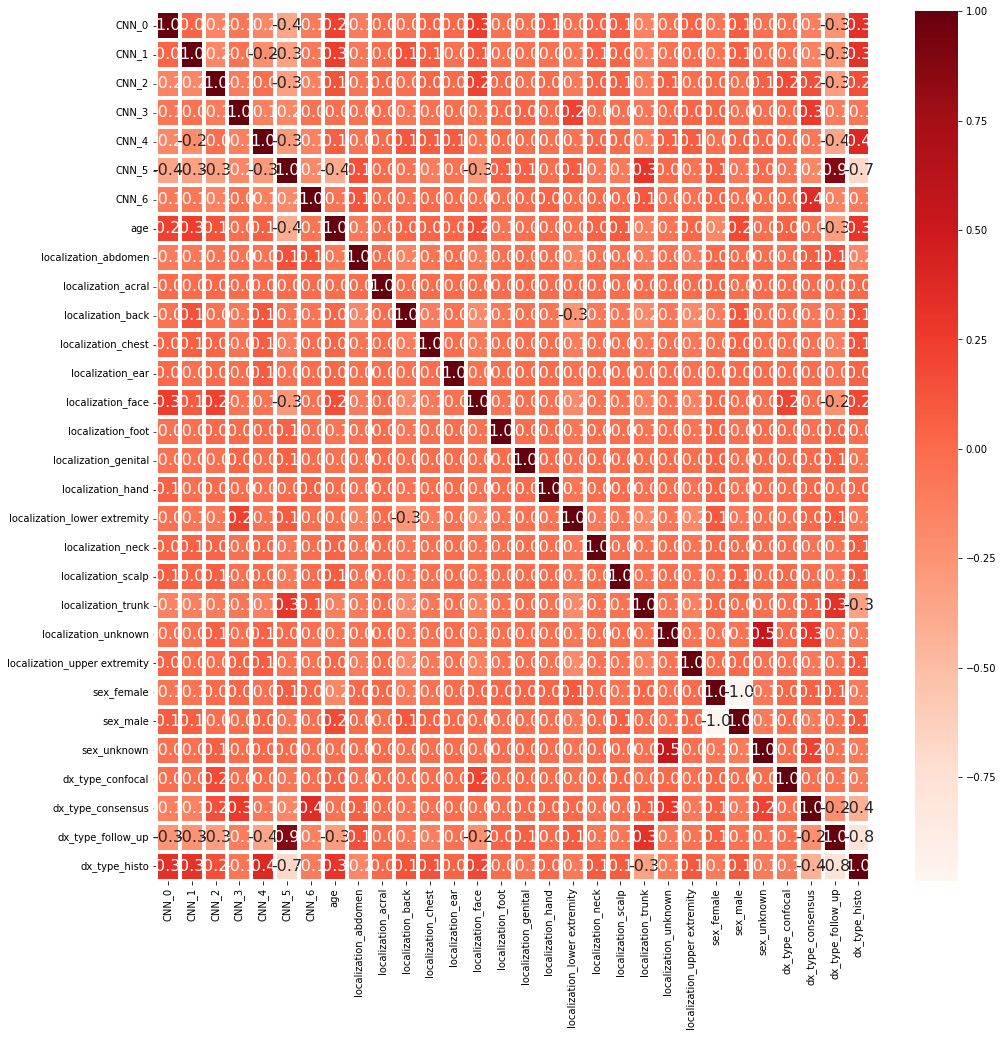

In [33]:
plt.subplots(figsize=(16,16))
f = sns.heatmap(train_data.corr(),annot=True, linewidths=4, fmt='.1f',cbar=True,annot_kws={"size": 16},cmap="Reds")
# plt.show(f)

In [18]:
RF_Model = sk.ensemble.RandomForestClassifier(max_depth = 50, random_state=0, n_estimators= 100, n_jobs=-1)
x_train = input_data_Array[0]
y_train = labels_Array[0]
x_test = input_data_Array[2]
y_test = labels_Array[2]
test_scores = []
parameters = []
# grid = {
#     'n_estimators': [500,1000,2000],
#     'max_depth': [10,25,50,80],
#     'bootstrap': [True, False]
# }

# grid = {
#     'n_estimators': [10,20,50,100],
#     'max_depth': [10,25,50],
#     'bootstrap': [True, False]
# }

grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [True, False]
}

for g in sk.model_selection.ParameterGrid(grid):
    parameters.append(g)
    RF_Model.set_params(**g)
    RF_Model.fit(x_train, y_train)
    test_scores.append(RF_Model.score(x_test, y_test))
best_one = np.argmax(test_scores)

best_param = parameters[best_one]

print(test_scores[best_one], best_param)

RF_Model.set_params(**best_param)
RF_Model.fit(x_train, y_train)

# RF_Model.fit(x_train, y_train)
# Y_pred = RF_Model.predict(x_test)
# print('------- Precision recal %--------')
# print(sk.metrics.classification_report(y_test,Y_pred))
# # print('-----log loss----------')
# # print (sk.metrics.log_loss(y_test,Y_pred))

0.7051597051597052 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=8,
                       max_features='auto', n_estimators=200, n_jobs=-1,
                       random_state=0)

In [41]:
# Model 280x210
model_ = RF_Model
X = input_data_Array[2]
Y = labels_Array[2]
# X = BLC_test_280x210[0]
# Y = BLC_test_280x210[1]
Y_pred = model_.predict(X)
results = model_evaluation(Y,Y_pred)
results

NameError: name 'model_evaluation' is not defined

In [ ]:
rfc=sk.ensemble.RandomForestClassifier(random_state=42, n_jobs=-1)
CV_rfc = sk.model_selection.GridSearchCV(estimator=rfc, param_grid=grid, cv= 5, n_jobs=-1)
x_train = input_data_Array[0]
y_train = labels_Array[0]
CV_rfc.fit(x_train, y_train)

In [13]:
CV_rfc.best_estimator_

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=200,
                       n_jobs=-1, random_state=42)

In [78]:
RF_Model2 = sk.ensemble.RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=200,random_state=42)
RF_Model2.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, max_features='log2', n_estimators=200,
                       random_state=42)

Nr. of Data : 
 451
Accuracy of The Model : 
 0.6674057649667405
Confusion Matrix : 
 [[12  2  2  0  3  2  0]
 [10 35  8  3  4  1  1]
 [ 1  9 88  2 18  7  0]
 [ 0  0  0  2  0  0  1]
 [ 7  2 17  0 62 17  3]
 [ 2  3  7  1 15 88  1]
 [ 0  0  0  0  1  0 14]]
Weighted Avg. of sensitivity : 
 0.6253335091635646
Weighted Avg. of specificity : 
 0.918620363689261


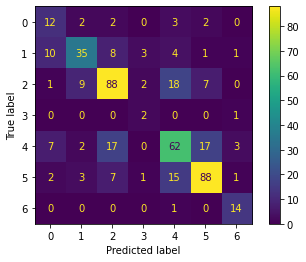

In [83]:
model_ = RF_Model
x = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(x)
confusion_matrix(Y_pred,Y)

(input_data_Array[0].argmax(axis=1) == labels_Array[0]).sum() / labels_Array[0].shape[0]

Nr. of Data : 
 451
Accuracy of The Model : 
 0.6873614190687362
Confusion Matrix : 
 [[20  3  4  1  3  0  0]
 [ 4 33  8  2  3  0  1]
 [ 2  7 81  1 20  6  0]
 [ 0  1  0  3  0  0  1]
 [ 5  4 22  1 62 11  3]
 [ 1  3  7  0 14 97  1]
 [ 0  0  0  0  1  1 14]]
Weighted Avg. of sensitivity : 
 0.6567003603700159
Weighted Avg. of specificity : 
 0.9233262659686655


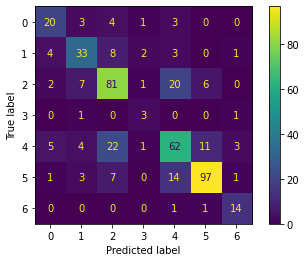

In [51]:
model_ = RF_Model
x = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(x)
confusion_matrix(Y_pred,Y)

Feature: 0 : dx_type, Score: 0.07090
Feature: 1 : age, Score: 0.05807
Feature: 2 : sex, Score: 0.01001
Feature: 3 : localization, Score: 0.04015
Feature: 4 : CNN_0, Score: 0.09142
Feature: 5 : CNN_1, Score: 0.10968
Feature: 6 : CNN_2, Score: 0.14406
Feature: 7 : CNN_3, Score: 0.07174
Feature: 8 : CNN_4, Score: 0.16700
Feature: 9 : CNN_5, Score: 0.15967
Feature: 10 : CNN_6, Score: 0.07731


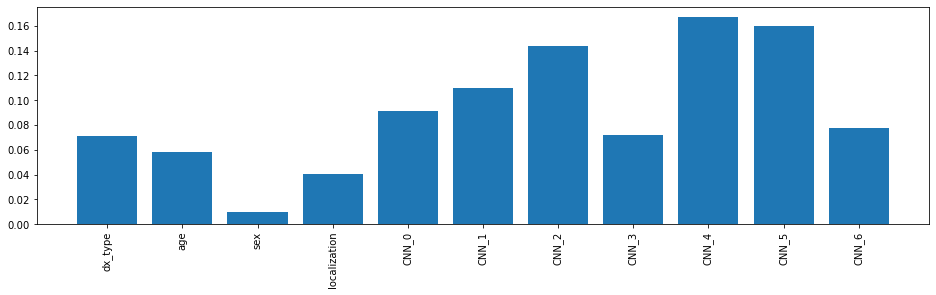

In [18]:
importance = RF_Model.feature_importances_

features_name = list(train_data.columns)
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d : %s, Score: %.5f' % (i,features_name[i],v))
# plot feature importance
plt.subplots(figsize=(16,4))
plt.xticks(rotation='vertical')
plt.bar(features_name, importance)
plt.show()

# **PCA**

In [ ]:
pca_ = sk.decompositionq.PCA()

ValueError: Could not interpret input 'Survived'

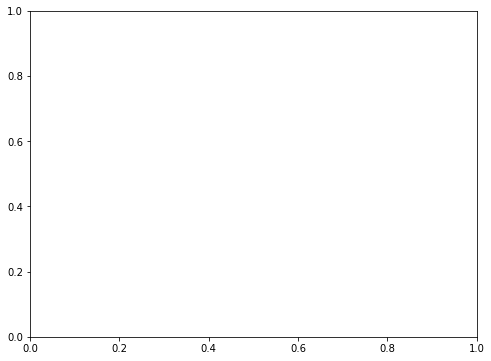

In [84]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train_data, hue='Embarked')
ax.set_ylim(0,500)
plt.title("Impact of Embarked on Survived")
plt.show()

In [68]:
df_ = train_data
cols = list(df_.columns)
lables_ = train_label
P_V = []
chi2 = []
for c in cols:
    csq = chi2_contingency(pd.crosstab(lables_, df_[c]))
    P_V.append(csq[1])
    chi2.append(csq[0])
    print('Variable: ', c, '\n' , "P-value: ",csq[1], 'Chi2: ', csq[0])

Variable:  age 
 P-value:  3.2229496104634663e-147 Chi2:  1029.4281637967515
Variable:  CNN_0 
 P-value:  0.021944141306088766 Chi2:  20700.0
Variable:  CNN_1 
 P-value:  0.021944141306088766 Chi2:  20700.0
Variable:  CNN_2 
 P-value:  0.021944141306087822 Chi2:  20700.000000000004
Variable:  CNN_3 
 P-value:  0.021944141306088766 Chi2:  20700.0
Variable:  CNN_4 
 P-value:  0.021944141306088766 Chi2:  20700.0
Variable:  CNN_5 
 P-value:  0.021944141306088766 Chi2:  20700.0
Variable:  CNN_6 
 P-value:  0.021944141306088766 Chi2:  20700.0
Variable:  localization_abdomen 
 P-value:  2.700795009988282e-19 Chi2:  99.84691250684885
Variable:  localization_back 
 P-value:  2.0819521325467966e-21 Chi2:  109.95614598123852
Variable:  localization_chest 
 P-value:  1.5088311418213472e-05 Chi2:  32.1773918367748
Variable:  localization_ear 
 P-value:  0.0483903880251194 Chi2:  12.681025820789316
Variable:  localization_face 
 P-value:  1.8624964159584824e-70 Chi2:  340.30203669944353
Variable:  l

Text(0.5, 1.0, 'Chi-Square')

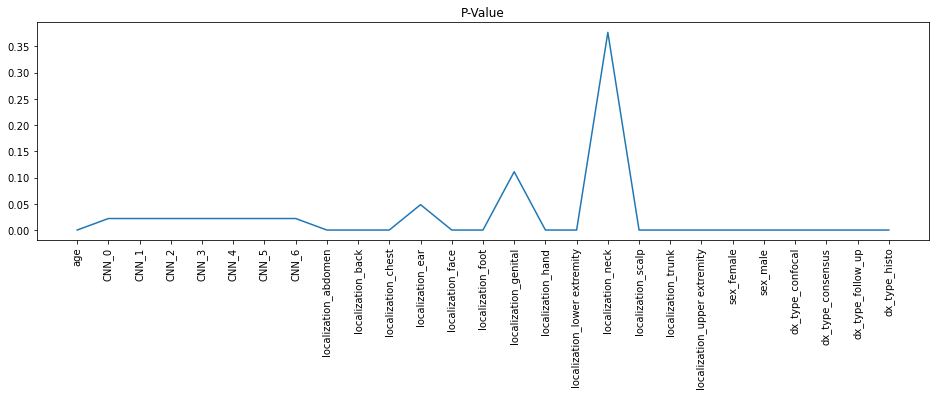

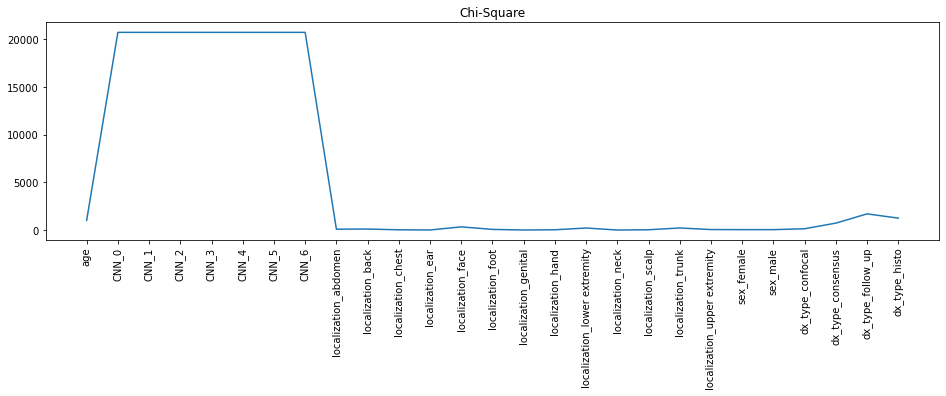

In [73]:

plt.subplots(figsize=(16,4))
plt.xticks(rotation='vertical')
plt.plot(cols, P_V)
plt.title('P-Value')


plt.subplots(figsize=(16,4))
plt.xticks(rotation='vertical')
plt.plot(cols, chi2)
plt.title('Chi-Square')

In [56]:
train_label.shape

(3450,)